In [1]:
#from mpi4py import MPI
import numpy as np
import pylab as plt

import VisModel as vm
from VisModel import utils
import uvtools
import hera_cal as hc
from pyuvdata import UVData
from pyuvsim.simsetup import initialize_uvdata_from_keywords

from hera_sim.visibilities import VisCPU, conversions
from hera_sim.beams import PolyBeam, PerturbedPolyBeam
from hera_sim.io import empty_uvdata
import vis_cpu

from astropy.time import Time
import ultranest
import time, copy, sys

In [2]:
def default_cfg():
    """
    Set parameter defaults.
    """
    # Simulation specification
    cfg_spec = dict( nfreq=16,
                     start_freq=1.e8,
                     channel_width=1e6,
                     start_time=2458902.33333,
                     integration_time=40.,
                     ntimes=3,
                     cat_name="gleamegc.dat",
                     apply_gains=True,
                     apply_noise=True,
                     ant_pert=False,
                     seed=None,
                     ant_pert_sigma=0.0,
                     use_legacy_array=False,
                     hex_spec=(3,4), 
                     hex_ants_per_row=None, 
                     hex_ant_sep=14.6,
                     use_ptsrc=True )
                        
    # Diffuse model specification
    cfg_diffuse = dict( use_diffuse=False,
                        nside=64,
                        obs_latitude=-30.7215277777,
                        obs_longitude = 21.4283055554,
                        obs_height = 1073,
                        beam_pol='XX',
                        diffuse_model='GSM',
                        eor_random_seed=42,
                        nprocs=1 )
    
    # Beam model parameters
    cfg_beam = dict( ref_freq=1.e8,
                     spectral_index=-0.6975,
                     #seed=None,
                     perturb_scale=0.0,
                     mainlobe_scale=1.0,
                     xstretch=1.0,
                     ystretch=1.0,
                     rotation=0.0,
                     mainlobe_width=0.3, 
                     beam_coeffs=[ 0.29778665, -0.44821433, 0.27338272, 
                                  -0.10030698, -0.01195859, 0.06063853, 
                                  -0.04593295,  0.0107879,  0.01390283, 
                                  -0.01881641, -0.00177106, 0.01265177, 
                                  -0.00568299, -0.00333975, 0.00452368,
                                   0.00151808, -0.00593812, 0.00351559
                                 ] )
    
    # Fluctuating gain model parameters
    cfg_gain = dict(nmodes=8, seed=None)
    
    # Noise parameters
    cfg_noise = dict(nsamp=1., seed=None, noise_file=None)
    
    # Combine into single dict
    cfg = { 'sim_beam':     cfg_beam,
            'sim_spec':     cfg_spec,
            'sim_diffuse':  cfg_diffuse,
            'sim_noise':    cfg_noise,
            'sim_gain':     cfg_gain,
           }
    return cfg

In [3]:
# Load template configuration
cfg = default_cfg()
cfg_spec = cfg['sim_spec']

# Observation time and location
obstime = Time("2018-08-31T04:02:30.11", format="isot", scale="utc")
hera_lat, hera_lon, hera_alt = -30.7215, 21.4283, 1073.0

# Initialise shape of data and antenna array
ants = utils.build_hex_array(hex_spec=cfg_spec['hex_spec'], 
                             ants_per_row=cfg_spec['hex_ants_per_row'], 
                             d=cfg_spec['hex_ant_sep'])


#uvd_init = utils.empty_uvdata(array_layout=ants, **cfg_spec)
uvd_init = initialize_uvdata_from_keywords(array_layout=ants,
                                           telescope_name="test_array",
                                           x_orientation="east",
                                           phase_type="drift",
                                           vis_units="Jy",
                                           complete=True,
                                           write_files=False,
                                           polarization_array=np.array(["XX",]),
                                           telescope_location=(hera_lat, hera_lon, hera_alt),
                                           Nfreqs=cfg_spec['nfreq'],
                                           start_freq=cfg_spec['start_freq'],
                                           start_time=obstime.jd,
                                           integration_time=cfg_spec['integration_time'],
                                           Ntimes=cfg_spec['ntimes'],
                                           channel_width=cfg_spec['channel_width'],
                                           )

# Point source catalogue
ra_dec, flux = utils.load_ptsrc_catalog('/home/phil/hera/non-redundant-pipeline/catBC.txt', 
                                        freq0=100e6, freqs=np.unique(uvd_init.freq_array), 
                                        usecols=(0,1,2,3))

In [4]:
# Sort by flux
idxs = np.argsort(flux[0,:])[::-1]
flux_sorted = flux[:,idxs]
ra_dec_sorted = ra_dec[idxs,:]

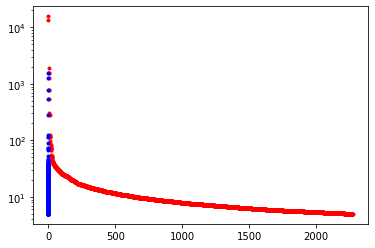

In [5]:
# Find sources that are above the horizon
_az, _za = vm.sources.source_az_za(lsts=np.unique(uvd_init.lst_array),
                                   ra=ra_dec_sorted[:,0],
                                   dec=ra_dec_sorted[:,1],
                                   latitude=np.deg2rad(-30.7215))
ra_dec_visible = ra_dec_sorted[np.where(_za[0] <= np.pi/2.)] # only look at 1st LST sample
flux_visible = flux_sorted[:,np.where(_za[0] <= np.pi/2.)]

plt.plot(flux_sorted[0,:], 'r.')
plt.plot(flux_visible[0,:], 'b.')
plt.yscale('log')

In [6]:
# Build gain model
tstart = np.min(uvd_init.time_array)
tend = np.max(uvd_init.time_array)
#default_params = np.array([1.0, 0.0, 0.0, 
#                           0.0, 0.0, 0.0, 
#                           1.0, 0.0, 
#                           0.0, 0.0,])
default_params = np.array([1., 0., 0., 0., 
                           1., 0., 0., 0.])
gain_model = vm.gains.FactorizedFourierGainModel(uvd_init, 
                                                 freq_range=(100e6, 115e6), 
                                                 time_range=(tstart, tend),
                                                 freq_modes=[0,1],
                                                 time_modes=[0,1],
                                                 default_params=default_params)

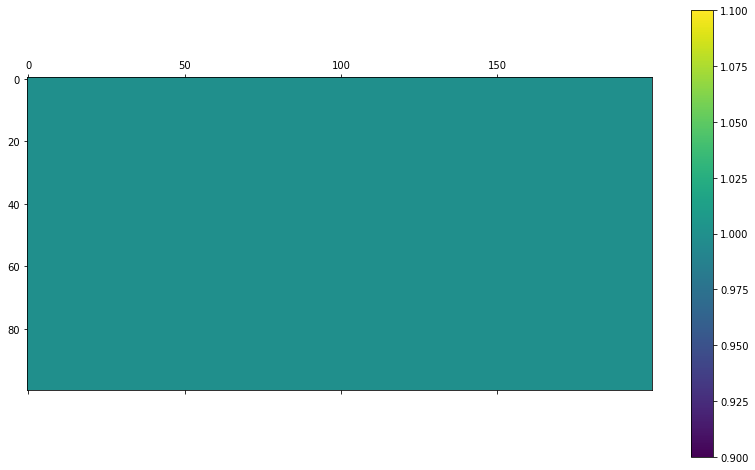

In [7]:
freqs = np.linspace(90e6, 220e6, 200)
times = np.linspace(0., 0.1, 100)
pp = default_params
g = gain_model.model(freqs, times, params=pp)
plt.matshow(g.real)
plt.colorbar()
plt.gcf().set_size_inches((14., 8.))

In [8]:
Nptsrc = 20
model = vm.VisModel(uvd_init, 
                    ra_dec_visible[:Nptsrc,:], flux_visible[:,0,:Nptsrc],
                    beam_model=PerturbedPolyBeam, 
                    default_beam_params=cfg['sim_beam'],
                    free_params_antpos=['antpos_dx', 'antpos_dy'], 
                    free_params_beam=['xstretch', 'ystretch', 'spectral_index'], 
                    free_params_ptsrc=['delta_ra', 'delta_dec', 'flux_factor'],
                    free_ants=np.arange(10),
                    free_beams=np.arange(10),
                    free_ptsrcs=np.arange(Nptsrc), # FIXME: What if not all ptsrc are free?
                    free_ants_gains=np.arange(10),
                    free_params_gains=gain_model.paramnames,
                    gain_model=gain_model,
                    comm=None)

In [10]:
# Set gain parameters for one antenna
model.set_gain_params(0, params=[1., 0., 0., 0.,
                                 1., 0., 0., 0.])
#model.set_gain_params(0, params=[1.0, 0.1, 0.1, 
#                                 0.0, 0.0, 0.0, 
#                                 1.0, 0.0, 
#                                 0.0, 0.0,])

In [11]:
# Initial values
init_beams  = np.ones(len(model.free_beams) * len(model.free_params_beam))
init_beams[2::3] *= -0.6975

init_antpos = np.zeros(len(model.free_ants) * len(model.free_params_antpos))
init_ptsrc = np.array([0.,0.,1.]*len(model.free_ptsrcs))

#g_init = np.array([1.0, 0.0, 0.0, 
#                   0.0, 0.0, 0.0, 
#                   1.0, 0.0, 
#                   0.0, 0.0,])
g_init = default_params
init_gains = np.tile(g_init, len(model.free_ants_gains)).reshape((len(model.free_ants_gains), -1))

In [12]:
init_vals = model.parameter_vector(antpos_params=init_antpos.reshape((len(model.free_ants), -1)), 
                                   beam_params=init_beams.reshape((len(model.free_beams), -1)), 
                                   gain_params=init_gains, 
                                   ptsrc_params=init_ptsrc.reshape((len(model.free_ptsrcs), -1)))

In [13]:
for v, n in zip(init_vals, model.param_names()):
    print("%25s %4.4e" % (n, v))

            antpos_dx_000 0.0000e+00
            antpos_dy_000 0.0000e+00
            antpos_dx_001 0.0000e+00
            antpos_dy_001 0.0000e+00
            antpos_dx_002 0.0000e+00
            antpos_dy_002 0.0000e+00
            antpos_dx_003 0.0000e+00
            antpos_dy_003 0.0000e+00
            antpos_dx_004 0.0000e+00
            antpos_dy_004 0.0000e+00
            antpos_dx_005 0.0000e+00
            antpos_dy_005 0.0000e+00
            antpos_dx_006 0.0000e+00
            antpos_dy_006 0.0000e+00
            antpos_dx_007 0.0000e+00
            antpos_dy_007 0.0000e+00
            antpos_dx_008 0.0000e+00
            antpos_dy_008 0.0000e+00
            antpos_dx_009 0.0000e+00
            antpos_dy_009 0.0000e+00
             xstretch_000 1.0000e+00
             ystretch_000 1.0000e+00
       spectral_index_000 -6.9750e-01
             xstretch_001 1.0000e+00
             ystretch_001 1.0000e+00
       spectral_index_001 -6.9750e-01
             xstretch_002 1.0000e+00

## Fisher matrix calculation

In [14]:
F = vm.calc_fisher_bigmem(model, fiducial=init_vals, var=0.5, dx=0.01, verbose=True)

0 / 190
1 / 190
2 / 190
3 / 190
4 / 190
5 / 190
6 / 190
7 / 190
8 / 190
9 / 190
10 / 190
11 / 190
12 / 190
13 / 190
14 / 190
15 / 190
16 / 190
17 / 190
18 / 190
19 / 190
20 / 190
21 / 190
22 / 190
23 / 190
24 / 190
25 / 190
26 / 190
27 / 190
28 / 190
29 / 190
30 / 190
31 / 190
32 / 190
33 / 190
34 / 190
35 / 190
36 / 190
37 / 190
38 / 190
39 / 190
40 / 190
41 / 190
42 / 190
43 / 190
44 / 190
45 / 190
46 / 190
47 / 190
48 / 190
49 / 190
50 / 190
51 / 190
52 / 190
53 / 190
54 / 190
55 / 190
56 / 190
57 / 190
58 / 190
59 / 190
60 / 190
61 / 190
62 / 190
63 / 190
64 / 190
65 / 190
66 / 190
67 / 190
68 / 190
69 / 190
70 / 190
71 / 190
72 / 190
73 / 190
74 / 190
75 / 190
76 / 190
77 / 190
78 / 190
79 / 190
80 / 190
81 / 190
82 / 190
83 / 190
84 / 190
85 / 190
86 / 190
87 / 190
88 / 190
89 / 190
90 / 190
91 / 190
92 / 190
93 / 190
94 / 190
95 / 190
96 / 190
97 / 190
98 / 190
99 / 190
100 / 190
101 / 190
102 / 190
103 / 190
104 / 190
105 / 190
106 / 190
107 / 190
108 / 190
109 / 190
110 / 190


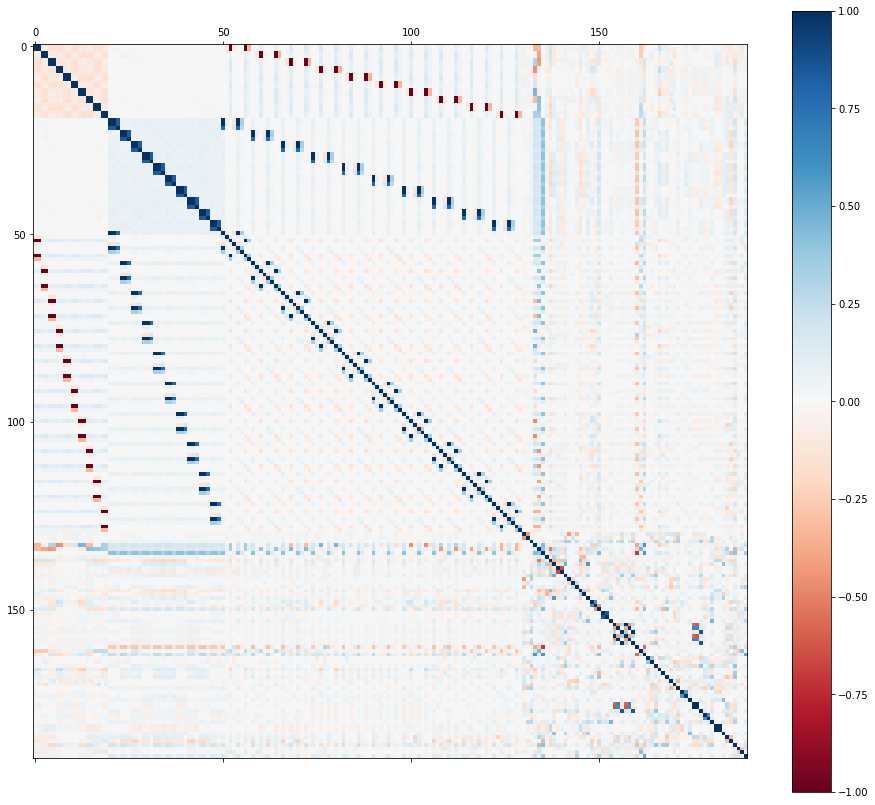

In [16]:
plt.matshow(vm.utils.corrmat(F), vmin=-1., vmax=1., cmap='RdBu')
plt.colorbar()
plt.gcf().set_size_inches((16., 14.))

In [17]:
for ff, nn in zip(np.diag(F), model.param_names()):
    print("%4.4e %30s" % (ff, nn))

1.9801e+07                  antpos_dx_000
7.1920e+05                  antpos_dy_000
1.9541e+07                  antpos_dx_001
6.9023e+05                  antpos_dy_001
1.9557e+07                  antpos_dx_002
6.9147e+05                  antpos_dy_002
1.9919e+07                  antpos_dx_003
7.4284e+05                  antpos_dy_003
1.9698e+07                  antpos_dx_004
7.2066e+05                  antpos_dy_004
1.9698e+07                  antpos_dx_005
7.2066e+05                  antpos_dy_005
1.9919e+07                  antpos_dx_006
7.4284e+05                  antpos_dy_006
1.9557e+07                  antpos_dx_007
6.9147e+05                  antpos_dy_007
1.9541e+07                  antpos_dx_008
6.9023e+05                  antpos_dy_008
1.9801e+07                  antpos_dx_009
7.1920e+05                  antpos_dy_009
1.9597e+07                   xstretch_000
7.7324e+06                   ystretch_000
3.1250e+05             spectral_index_000
1.9471e+07                   xstre

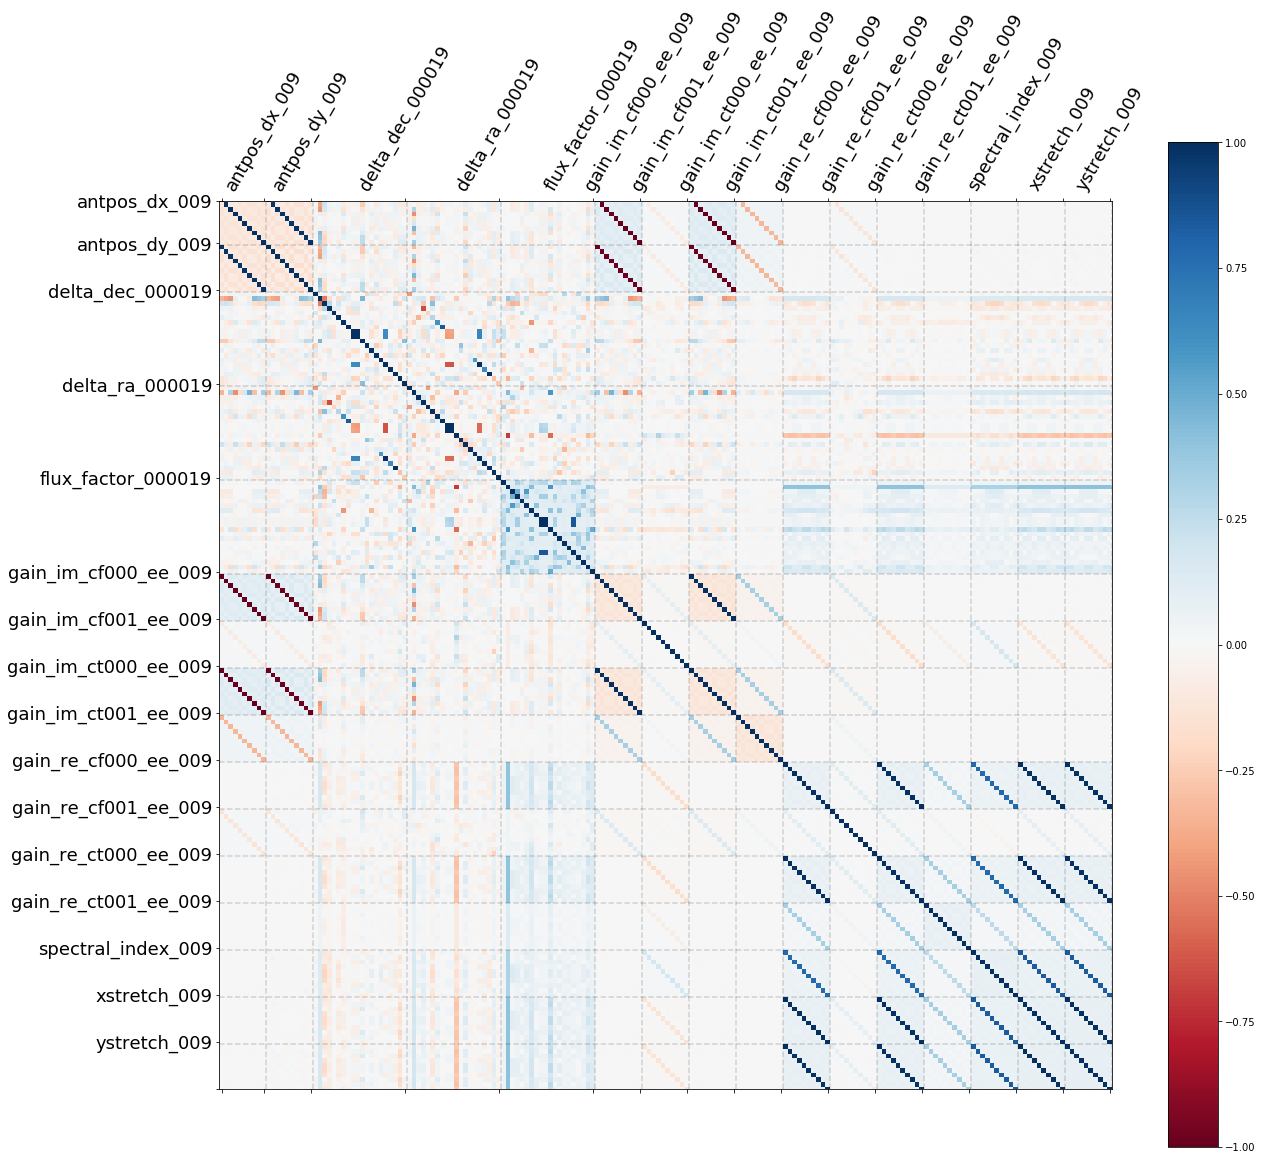

In [36]:
blocks = [9, 19, 39, 59, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189]

pnames_reordered, F_reordered = vm.utils.reorder_matrix(model.param_names(), F)
plt.matshow(vm.utils.corrmat(F_reordered), vmin=-1., vmax=1., cmap='RdBu')

block_lbls = []
for b in blocks:
    plt.axhline(b+0.5, color='k', ls='dashed', alpha=0.15)
    plt.axvline(b+0.5, color='k', ls='dashed', alpha=0.15)
    block_lbls.append(pnames_reordered[b])

ax = plt.gca()
ax.set_xticks([0,] + blocks)
ax.set_yticks([0,] + blocks)
ax.set_xticklabels(["",] + block_lbls, fontsize=18, rotation=60)
ax.set_yticklabels(block_lbls, fontsize=18)
    
plt.colorbar()
plt.gcf().set_size_inches((20., 18.))

In [25]:

for i, pn in enumerate(pnames_reordered):
    print("%03d %30s" % (i, pn))

000                  antpos_dx_000
001                  antpos_dx_001
002                  antpos_dx_002
003                  antpos_dx_003
004                  antpos_dx_004
005                  antpos_dx_005
006                  antpos_dx_006
007                  antpos_dx_007
008                  antpos_dx_008
009                  antpos_dx_009
010                  antpos_dy_000
011                  antpos_dy_001
012                  antpos_dy_002
013                  antpos_dy_003
014                  antpos_dy_004
015                  antpos_dy_005
016                  antpos_dy_006
017                  antpos_dy_007
018                  antpos_dy_008
019                  antpos_dy_009
020               delta_dec_000000
021               delta_dec_000001
022               delta_dec_000002
023               delta_dec_000003
024               delta_dec_000004
025               delta_dec_000005
026               delta_dec_000006
027               delta_dec_000007
028               de

## Testing gains

In [ ]:
model.gain_params